In [ ]:
# %%

import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
from config import *
from data.dataset import MixtureDataset
from tqdm import tqdm
from torchlibrosa.stft import STFT, ISTFT, magphase

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [ ]:
# %%

class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super(ResidualBlock, self).__init__()

        self.residual_block = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(
            in_c, out_c, kernel_size=1, stride=stride, padding=0)

    def forward(self, inputs):
        x = self.residual_block(inputs)
        s = self.shortcut(inputs)

        skip = x + s
        return skip


class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(DecoderBlock, self).__init__()
        self.upsampling = nn.ConvTranspose2d(
            in_c, out_c, kernel_size=2, stride=2, padding=0, dilation=1)
        self.residual_block = ResidualBlock(
            out_c * 2, out_c)
        # self.upsampling = nn.Upsample(
        #     scale_factor=2, mode='bilinear', align_corners=True)
        # self.residual_block = ResidualBlock(
        #     in_c + out_c, out_c)

    def forward(self, x, skip):
        # Upsample
        x = self.upsampling(x)
        # Ensure x and skip have the same spatial dimensions
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(
                x, size=(skip.shape[2], skip.shape[3]), mode='bilinear', align_corners=True)

        # Concatenate
        x = torch.cat([x, skip], dim=1)

        # Residual block
        x = self.residual_block(x)

        return x


class ResUNet(nn.Module):
    def __init__(self, in_c, out_c):
        super(ResUNet, self).__init__()

        """ Encoder 1 """
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0)
        # self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1, padding="same"),

        """ Encoder 2 and 3"""
        self.encoder_block2 = ResidualBlock(
            out_c, out_c * 2, stride=2)
        self.encoder_block3 = ResidualBlock(
            out_c * 2, out_c * 4, stride=2)

        # layer for the classifier
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(out_c * 4, out_c * 8, kernel_size=1, padding=0),
        #     nn.BatchNorm2d(out_c * 8),
        #     nn.ReLU(),
        #     nn.Conv2d(out_c * 8, out_c * 8, kernel_size=1, padding=0),
        #     nn.BatchNorm2d(out_c * 8),
        #     nn.ReLU(),
        #     nn.Linear(out_c * 8, 8)
        # )

        """ Bridge """
        self.bridge = ResidualBlock(
            out_c * 4, out_c * 8, stride=2)

        """ Decoder """
        self.decoder_block1 = DecoderBlock(out_c * 8, out_c * 4)
        self.decoder_block2 = DecoderBlock(out_c * 4, out_c * 2)
        self.decoder_block3 = DecoderBlock(out_c * 2, out_c)

        """ Output """
        # self.last_layer = nn.Sequential(
        #     # nn.Conv2d(out_c, 1, kernel_size=1, padding='same'),
        #     nn.Conv2d(out_c, 1, kernel_size=1, padding=0),
        #     # nn.Sigmoid()
        # )

        # Output layers
        self.mag_mask_layer = nn.Sequential(
            nn.Conv2d(out_c, 1, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

        self.real_mask_layer = nn.Sequential(
            nn.Conv2d(out_c, 1, kernel_size=1, padding=0),
            nn.Tanh()
        )

        self.imag_mask_layer = nn.Sequential(
            nn.Conv2d(out_c, 1, kernel_size=1, padding=0),
            nn.Tanh()
        )

    def forward(self, inputs):

        inputs = inputs.unsqueeze(1)

        """ Encoder 1 """
        encoder1 = self.encoder_block1(inputs)
        s = self.shortcut(inputs)
        skip1 = encoder1 + s

        """ Encoder 2 and 3 """
        skip2 = self.encoder_block2(skip1)
        skip3 = self.encoder_block3(skip2)

        """ Bridge """
        bridge = self.bridge(skip3)

        """ Decoder """
        decoder1 = self.decoder_block1(bridge, skip3)
        decoder2 = self.decoder_block2(decoder1, skip2)
        decoder3 = self.decoder_block3(decoder2, skip1)

        """ Output """
        # output = self.last_layer(decoder3)

        # mag_mask = torch.sigmoid(output)
        # real_mask = torch.tanh(output)
        # imag_mask = torch.tanh(output)

        mag_mask = self.mag_mask_layer(decoder3)
        real_mask = self.real_mask_layer(decoder3)
        imag_mask = self.imag_mask_layer(decoder3)

        return mag_mask, real_mask, imag_mask, skip3


class MultiTaskResUNet(nn.Module):
    def __init__(self, num_noise_classes):
        super().__init__()
        self.resunet = ResUNet(in_c=1, out_c=32)

        self.classifier = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Add max pooling here
            nn.Dropout(0.3),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Add max pooling here
            nn.Dropout(0.3),
        )

        # output classifier with sigmoid activation
        self.classifier_output = nn.Sequential(
            nn.Linear(32 * 8 * 30, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_noise_classes),  # Corrected the input size to 64
            nn.Sigmoid()
        )

    def forward(self, x):
        mag_mask, real_mask, imag_mask, skip3 = self.resunet(x)
        x = self.classifier(skip3)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier_output(x)
        return mag_mask, real_mask, imag_mask, x

In [ ]:
# %%

# Define the multi-task loss function


def multi_task_loss(separation_output, classification_output, true_percussion, true_class, alpha=0.7, beta=0.3):
    mse_loss = nn.MSELoss()

    separation_loss = mse_loss(separation_output, true_percussion)
    classification_loss = nn.CrossEntropyLoss()(
        classification_output, true_class)

    return alpha * separation_loss + beta * classification_loss

In [ ]:
# %%

# Load metadata
metadata = pd.read_csv(os.path.join(
    DATASET_MIX_AUDIO_PATH, "metadata.csv"))

# define the train, validation and test sets

dataset = MixtureDataset(metadata_file=metadata, k=0.8, noise_class=None)
# Split the dataset into training, validation and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

In [ ]:
# %%

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# %%

# save the dataloaders
# torch.save(train_loader, 'train_loader.pth')
# torch.save(val_loader, 'val_loader.pth')
# torch.save(test_loader, 'test_loader.pth')

In [ ]:
# %%

# Define the model, optimizer and loss function
model = MultiTaskResUNet(num_noise_classes=8).to('cuda')
optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = multi_task_loss
device = "cuda"
# Train the model

In [ ]:
# %%

model = MultiTaskResUNet(num_noise_classes=8).to('cuda')
device = 'cuda'
# Test the model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0
test_loss_list = []
for batch in tqdm(test_loader):
    # Move data to device
    mixture = batch['mixture audio'].to(device)
    true_percussion = batch['percussion audio'].to(device)
    true_class = batch['noise class'].to(device)
    
    # calculate real and imaginary parts of the mixture
    mix_stft = torch.stft(
        mixture.to(device), n_fft=256, hop_length=64, win_length=256, window=torch.hann_window(window_length=256, device=device), return_complex=True)
    
    # calculate magnitude and phase of the mixture
    mix_mag, mix_cos, mix_sin = magphase(mix_stft.real, mix_stft.imag)
    
    # forward pass
    mag_mask, real_mask, imag_mask, class_output = model(
        mix_mag)

    # remove the channel dimension from the output
    mag_mask = mag_mask.squeeze(1)
    real_mask = real_mask.squeeze(1)
    imag_mask = imag_mask.squeeze(1)
    
    # calculate mask cos and sin
    _, mask_cos, mask_sin = magphase(real_mask, imag_mask)
    
    # out cos and sin
    out_cos = mix_cos * mask_cos - \
        mix_sin * mask_sin
    out_sin = mix_sin * mask_cos + \
        mix_cos * mask_sin

    # calculate the |Y|
    out_mag = mix_mag * mag_mask

    # calculate the real and imaginary parts of the output
    out_real = out_mag * out_cos
    out_imag = out_mag * out_sin

    stft = out_real + 1j * out_imag

    percussion_sep = torch.istft(
        stft, n_fft=256, hop_length=64, win_length=256, window=torch.hann_window(256, device=device), length=31248)

    # calculate the loss
    loss = criterion(percussion_sep, class_output,
                        true_percussion, true_class)

    test_loss += loss.item()

    test_loss /= len(test_loader)
    test_loss_list.append(test_loss)

<ipython-input-17-ba9e14400f9f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
100%|██████████| 90/90 [00:26<00:00,  3.

In [ ]:
# %%

# listen to the mixture, percussion and the separated percussion
import soundfile as sf

# (batchsize, 31248) 9, 31248
mixture = mixture.cpu().numpy()
percussion = true_percussion.cpu().numpy()
separated_percussion = percussion_sep.cpu().detach().numpy()

# save them all
for i in range(8):
    sf.write(f'mixture_{i}.wav', mixture[i], 31248)
    sf.write(f'percussion_{i}.wav', percussion[i], 31248)
    sf.write(f'separated_percussion_{i}.wav', separated_percussion[i], 31248)

In [ ]:
#%%

# save them all
for i in range(8):
    sf.write(f'mixture_{i}.wav', mixture[i], 7812)
    sf.write(f'percussion_{i}.wav', percussion[i], 7812) 
    sf.write(f'separated_percussion_{i}.wav', separated_percussion[i], 7812)

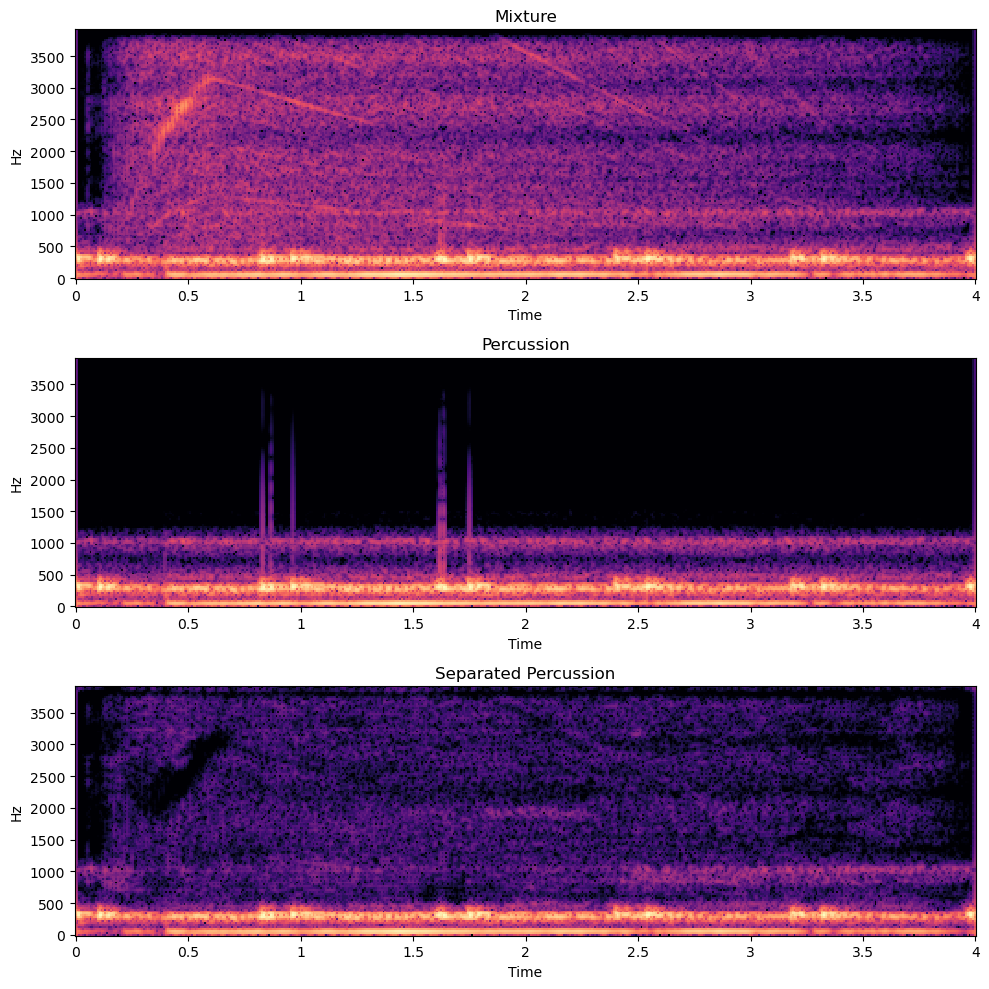

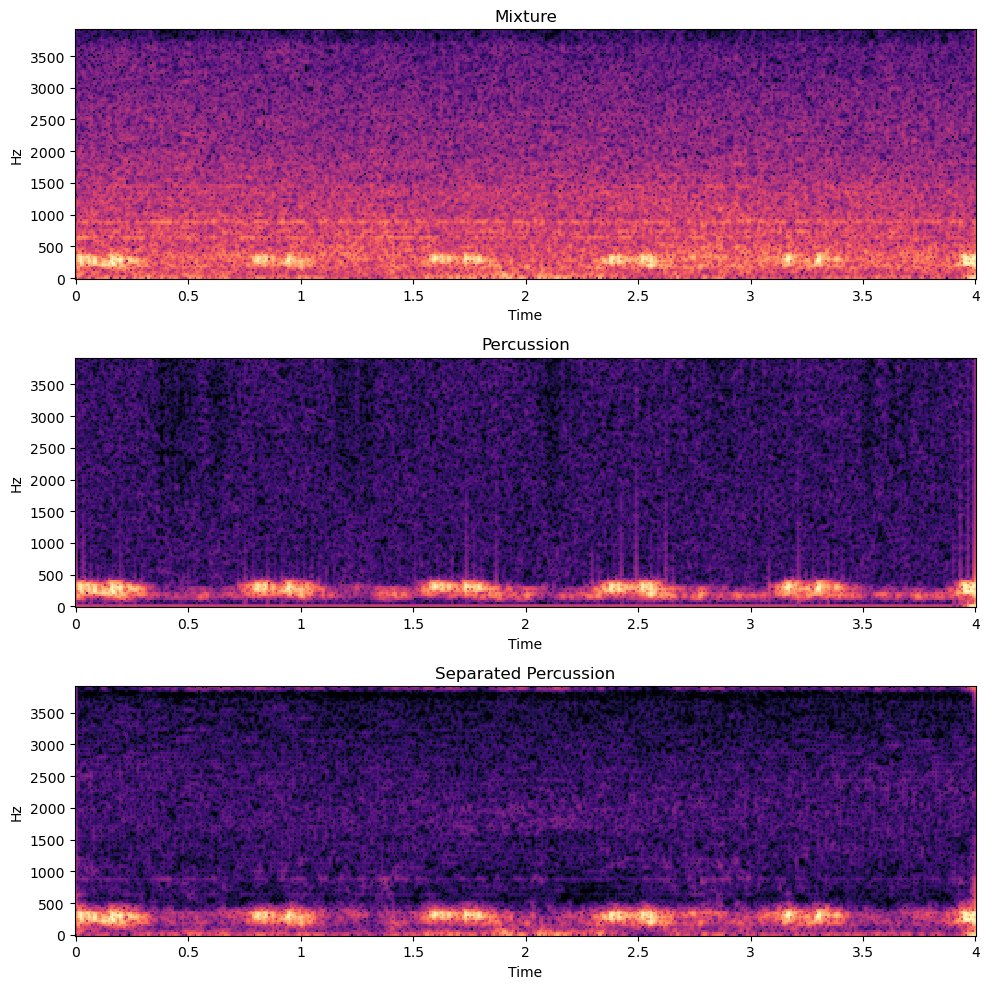

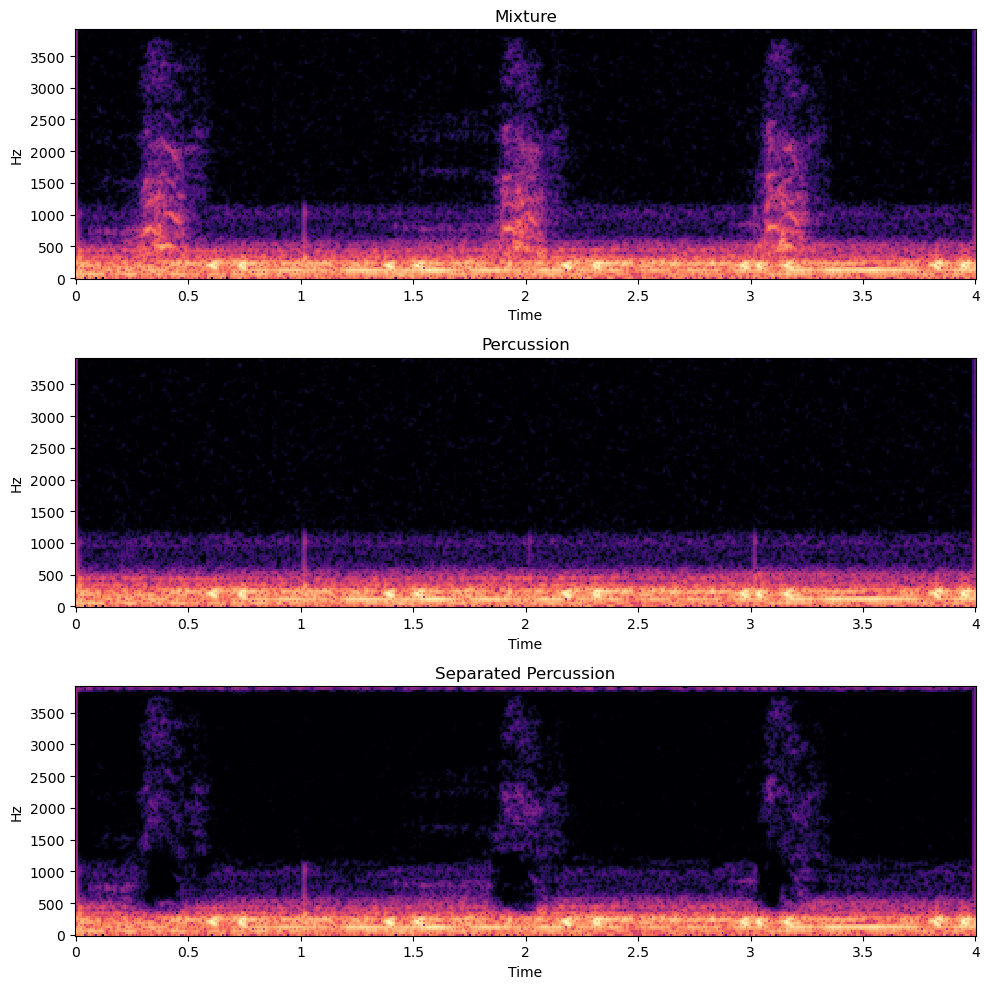

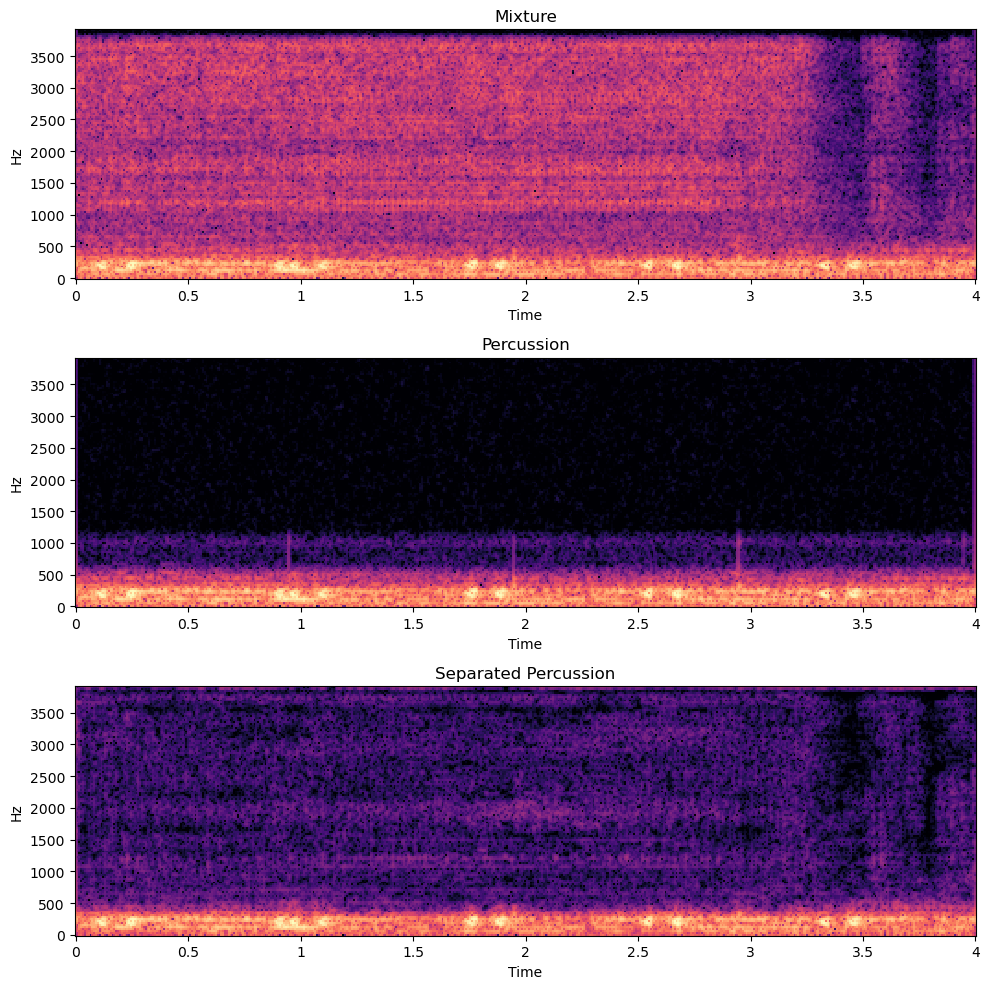

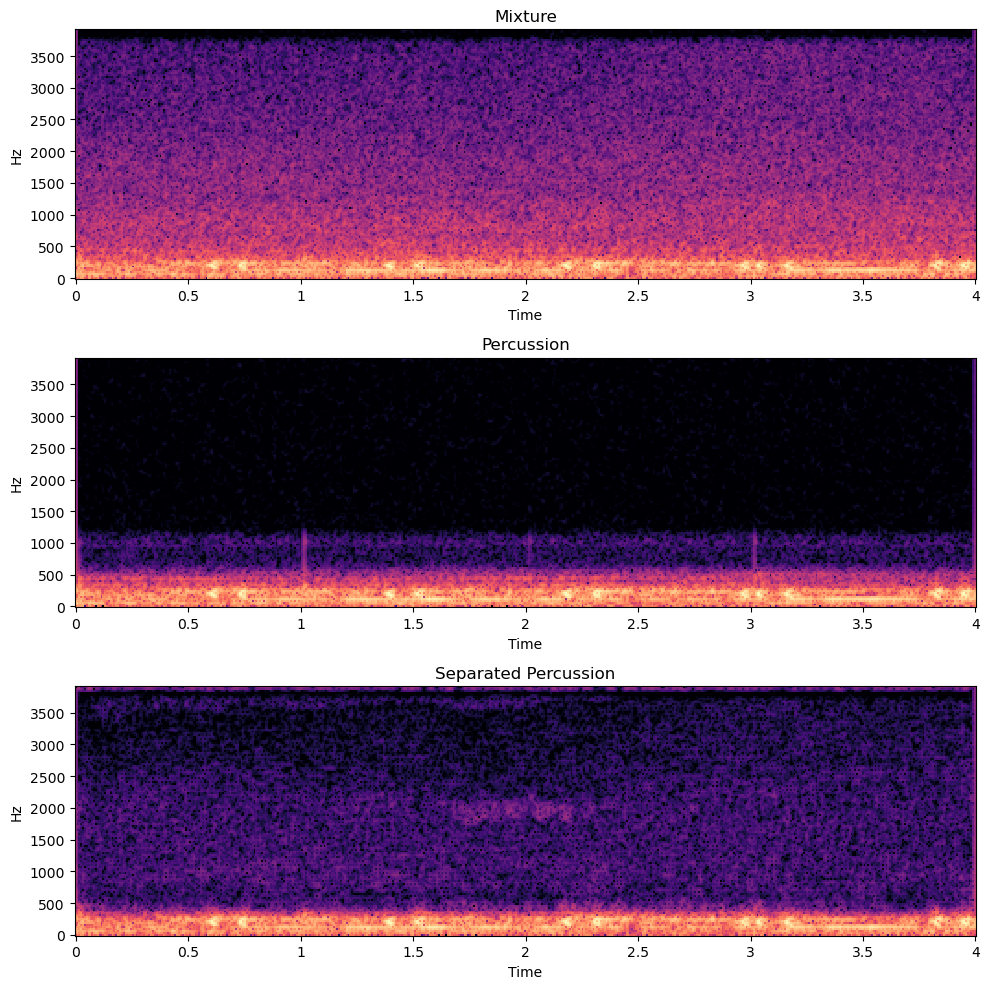

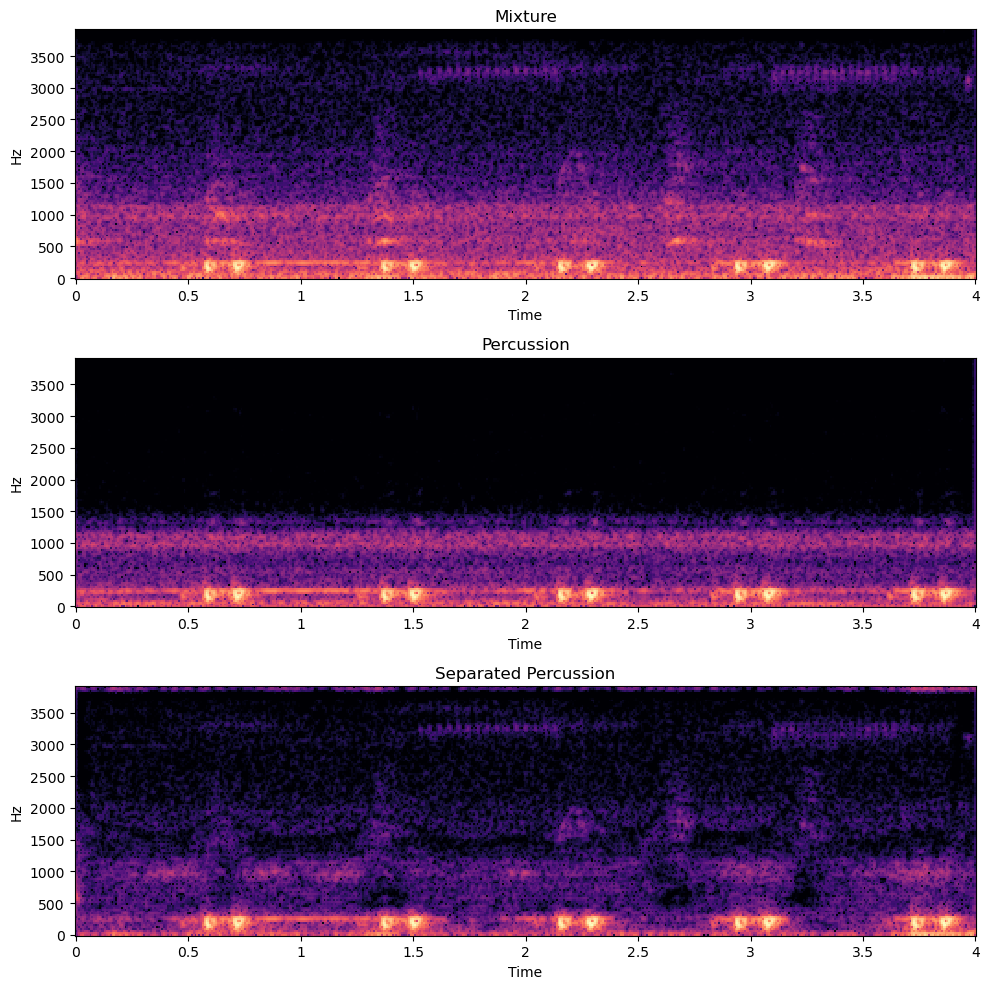

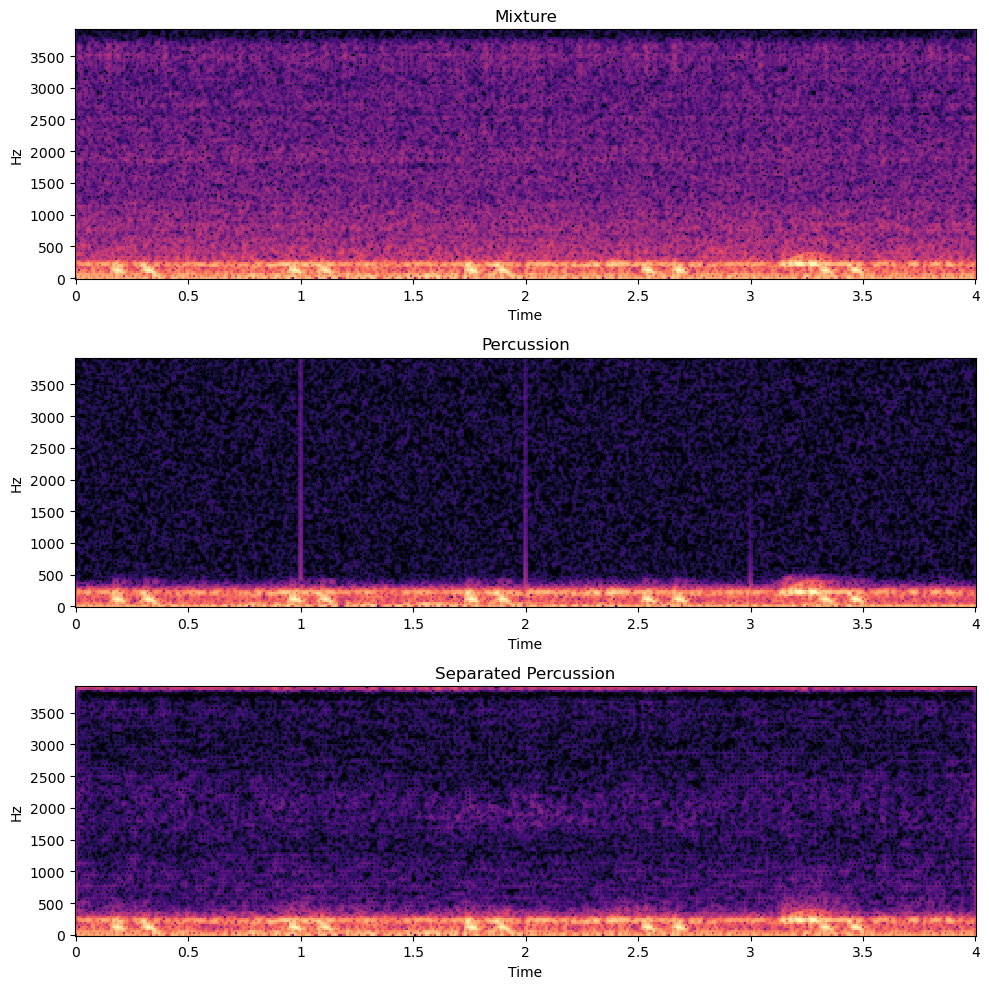

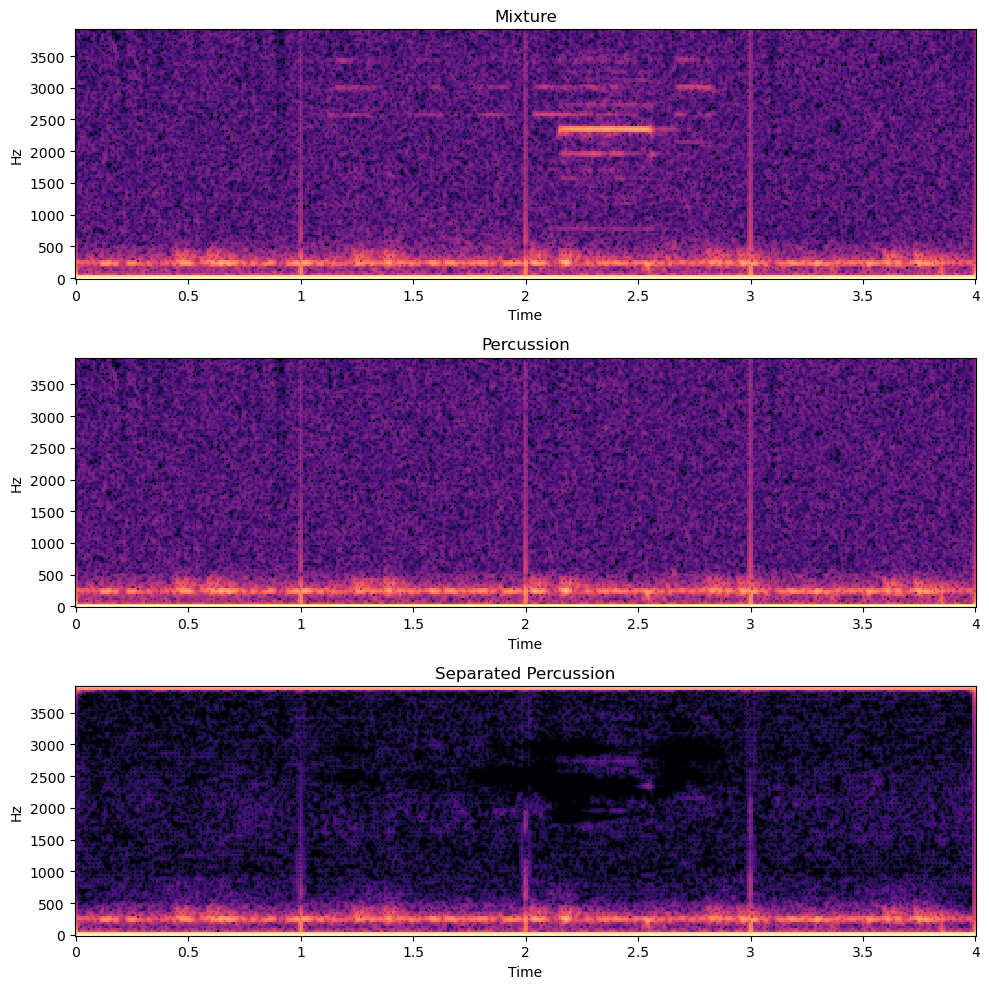

In [ ]:
# %%

# plot the spectrogram of the mixture, percussion and separated percussion

for i in range(8):
    fig, ax = plt.subplots(3, 1, figsize=(10, 10))
    # mixture
    mix_stft = librosa.stft(
        mixture[i], n_fft=256, hop_length=64, win_length=256)
    mix_mag, _ = librosa.magphase(mix_stft)
    librosa.display.specshow(librosa.amplitude_to_db(
        mix_mag, ref=np.max), sr=7812, hop_length=64, x_axis='time', y_axis='linear', ax=ax[0])
    ax[0].set_title('Mixture')
    # percussion
    perc_stft = librosa.stft(
        percussion[i], n_fft=256, hop_length=64, win_length=256)
    perc_mag, _ = librosa.magphase(perc_stft)
    librosa.display.specshow(librosa.amplitude_to_db(
        perc_mag, ref=np.max), sr=7812, hop_length=64, x_axis='time', y_axis='linear', ax=ax[1])
    ax[1].set_title('Percussion')
    # separated percussion
    sep_stft = librosa.stft(
        separated_percussion[i], n_fft=256, hop_length=64, win_length=256)
    sep_mag, _ = librosa.magphase(sep_stft)
    librosa.display.specshow(librosa.amplitude_to_db(
        sep_mag, ref=np.max), sr=7812, hop_length=64, x_axis='time', y_axis='linear', ax=ax[2])
    ax[2].set_title('Separated Percussion')
    plt.tight_layout()
    plt.show()